In [ ]:
from datetime import datetime, timezone, timedelta
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import netCDF4 as nc
import xarray as xr
import cfgrib
sys.path.append('../sdpm_py_util')
sys.path.append('../web_util')

import ocn_functions as ocnfuns
import plotting_functions as pltfuns
import atm_functions as atmfuns
import init_funs as initfuns
import hind_functions as hindfuns
import grid_functions as grdfuns
import web_functions as webfuns
from get_PFM_info import get_PFM_info
from util_functions import s_coordinate_4
from util_functions import display_timing_info
import observation_functions as obsfuns


#from make_LV4_dotin_and_SLURM import make_LV4_dotin_and_SLURM
from make_LV4_coawst_dotins_dotsb import make_LV4_coawst_dotins_dotsb

from run_slurm_LV4 import run_slurm_LV4

import cfgrib
import pickle
import os
##import pprint
import subprocess
#import grib2io

# latest anaconda
# https://repo.anaconda.com/archive/Anaconda3-2024.10-1-Linux-x86_64.sh
# wget https://repo.continuum.io/archive/Anaconda3-2018.12-Linux-x86_64.sh
# wget https://repo.anaconda.com/archive/Anaconda3-2024.10-1-Linux-x86_64.sh


/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:32: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


ModuleNotFoundError: No module named 'grib2io'

In [ ]:

grb2_out = "/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_003.grb2"


ds = xr.open_dataset(grb2_out, engine='cfgrib',filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'surface'})
#ds = cfgrib.open_file(grb2_out)
#ds = grib2io.open(grb2_out)

print(ds)
lon = ds.variables['longitude'].data[:]
lat = ds.variables['latitude'].data[:]
time = ds.variables['time']
dt = ds.variables['step']
print(np.shape(lon))
print(time.data)
print(dt.data)

<xarray.Dataset> Size: 44MB
Dimensions:     (y: 428, x: 614)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 2MB ...
    longitude   (y, x) float64 2MB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables: (12/38)
    vis         (y, x) float32 1MB ...
    gust        (y, x) float32 1MB ...
    hindex      (y, x) float32 1MB ...
    sp          (y, x) float32 1MB ...
    orog        (y, x) float32 1MB ...
    t           (y, x) float32 1MB ...
    ...          ...
    ishf        (y, x) float32 1MB ...
    slhtf       (y, x) float32 1MB ...
    sdswrf      (y, x) float32 1MB ...
    sdlwrf      (y, x) float32 1MB ...
    suswrf      (y, x) float32 1MB ...
    sulwrf      (y, x) float32 1MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_su

In [2]:
cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_as_dict']
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../sdpm_py_util')

getting the ecmwf data from cdip for the 2025021412 forecast...
return code: 0 (0=good)
...done.

putting all grib data into a single pickle file...
there are 101 ecmwf grib files to stack in time.


Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021412011.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021412011.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021413001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021414001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021415001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021416001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021417001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021418001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0214122025021419001.90c91.idx' older than GR


ecmwf 1st ATM dict saved with pickle.
return code: 0 (0=good)
...done.

going from ecmwf variables to roms variables...

ecmwf ATM dict roms vars saved with pickle.
return code: 0 (0=good)
...done.
return code: 0 (0=good)


loading /scratch/PFM_Simulations/LV1_Forecast/Forc/atm_tmp_pckl_file.pkl ...
dict_keys(['lon', 'lat', 'ocean_time', 'pair_time', 'tair_time', 'qair_time', 'wind_time', 'rain_time', 'srf_time', 'lrf_time', 'ocean_time_ref', 'lwrad', 'lwrad_down', 'swrad', 'rain', 'Tair', 'Pair', 'Qair', 'Uwind', 'Vwind', 'vinfo'])
(101, 91, 91)


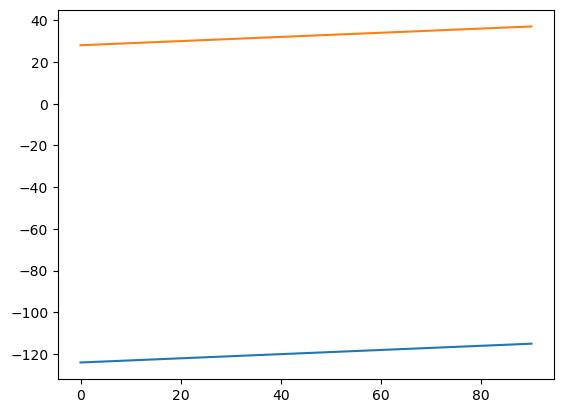

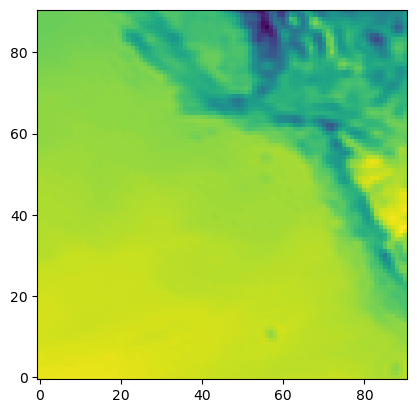

In [4]:
PFM=get_PFM_info()
fname_atm  = PFM['lv1_forc_dir'] + '/' + PFM['atm_tmp_pckl_file']
with open(fname_atm,'rb') as fp:
    print('loading ' + fname_atm + ' ...')
    ATM = pickle.load(fp)

print(ATM.keys())    
print(np.shape(ATM['Tair']))
fig, ax = plt.subplots()
pp=ax.plot(ATM['lon'])
pp=ax.plot(ATM['lat'])

fig, ax = plt.subplots()
ax.imshow(ATM['Tair'][0,:,:], origin='lower')



In [6]:

cmd_list = ['python','-W','ignore','atm_functions.py','get_atm_data_on_roms_grid',str(1)]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)   
print('return code: ' + str(ret5.returncode) + ' (0=good)')  
os.chdir('../driver')




loading /scratch/PFM_Simulations/LV1_Forecast/Forc/atm_tmp_pckl_file.pkl ...
interpolating to 1 grid...
... done.
rotating velocities to LV 1 roms directions...
... done.
saving to 1 pkl file.

ATM on roms grid dict saved with pickle.
return code: 0 (0=good)


In [7]:
pltfuns.plot_all_fields_in_one(str(1))


<Figure size 640x480 with 0 Axes>

In [ ]:


fn_pkl = '/scratch/PFM_Simulations/LV1_Forecast/Forc/hycom_tmp_pckl_file.pkl'
ocnfuns.make_all_tmp_pckl_ocnR_files_1hrzeta(fn_pkl)


In [3]:
cmd_list = ['python','ocn_functions.py','make_all_tmp_pckl_ocnR_files_1hrzeta',fn_pkl]
os.chdir('../sdpm_py_util')
ret1 = subprocess.run(cmd_list)     
#ocnfuns.make_all_tmp_pckl_ocnR_files(fn_pckl)
os.chdir('../driver')



/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_functions.py:30: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


and saving 18 pickle files...
...done. 
all 18 ocnR pickle files were made correctly


In [3]:
PFM = get_PFM_info()
print( PFM['atm_model'])
print( PFM['forecast_days'])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    type: atmospheric forcing file fields for surface fluxes
    time info: ocean time is from 1999/01/01 00:00:00
    coordinates: lat lon ocean_time
    dimensions(sizes): lrf_time(94), er(1141), xr(486), time(93), srf_time(94), rain_time(94), tair_time(93), pair_time(93), qair_time(93), wind_time(93)
    variables(dimensions): float64 lwrad(lrf_time, er, xr), float64 lat(er, xr), float64 lon(er, xr), float64 ocean_time(time), float64 lrf_time(lrf_time), float64 lwrad_down(lrf_time, er, xr), float64 swrad(srf_time, er, xr), float64 rain(rain_time, er, xr), float64 rain_time(rain_time), float64 Tair(tair_time, er, xr), float64 tair_time(tair_time), float64 Pair(pair_time, er, xr), float64 pair_time(pair_time), float64 Qair(qair_time, er, xr), float64 qair_time(qair_time), float64 Uwind(wind_time, er, xr), float64 wind_time(wind_time), float64 Vwind(wind_time, er, xr)
    groups: 


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    type: atmospheric forcing file fields for surface fluxes
    time info: ocean time is from 1999/01/01 00:00:00
    coordinates: ocean_time lon lat
    dimensions(sizes): tair_time(41), er(390), xr(253), pair_time(41), qair_time(41), wind_time(41), rain_time(41), srf_time(41), lrf_time(41), time(41)
    variables(dimensions): float64 Tair(tair_time, er, xr), float64 Pair(pair_time, er, xr), float64 Qair(qair_time, er, xr), float64 Uwind(wind_time, er, xr), float64 Vwind(wind_time, er, xr), float64 rain(rain_time, er, xr), float64 swrad(srf_time, er, xr), float64 lwrad(lrf_time, er, xr), float64 lwrad_down(lrf_time, er, xr), float64 lat(er, xr), float64 lon(er, xr), float64 ocean_time(time), float64 tair_time(tair_time), float64 pair_time(pair_time), float64 qair_time(qair_time), float64 wind_time(wind_time), float64 rain_time(rain_time), float64 srf_time(srf_time), float64 lrf_time(lrf_time)
    gr

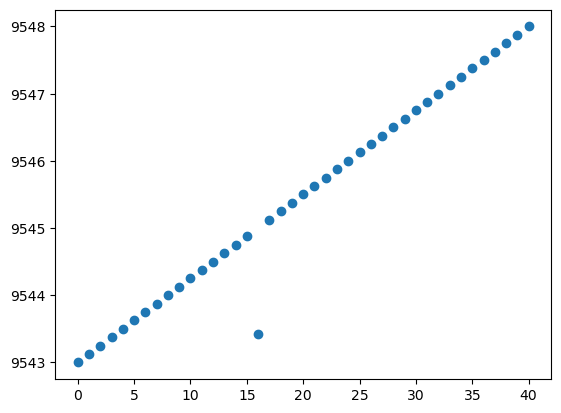

In [5]:

fn_atm = '/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_ATM_FORCING.nc'
ds = nc.Dataset(fn_atm)
print(ds)
print(ds.variables['tair_time'][:])

fig, ax = plt.subplots()
pp=ax.plot(ds.variables['tair_time'][:],'o')



In [ ]:

atmfuns.get_atm_data_on_roms_grid_to_atmnc('4')

In [5]:
# Create an initial dataset and save it to a NetCDF file
#ds1 = xr.Dataset({'var1': ('x', np.arange(5))}, coords={'x': np.arange(5)})
ATM_R = dict()
ATM_R['Tair'] = np.ones((5,2,3))
ATM_R['Pair'] = np.ones((5,2,3))
ATM_R['lat'] = np.ones((2,3))
ATM_R['lon'] = np.ones((2,3))
ATM_R['tair_time'] = np.array([1,2,3,4,5])
ATM_R['pair_time'] = ATM_R['tair_time']
ATM_R['ocean_time'] = ATM_R['tair_time']
ATM_R['ocean_time_ref'] = datetime.now()

ATM_R['vinfo'] = dict()
ATM_R['vinfo']['lon'] = {'long_name':'longitude',
                'units':'degrees_east'}
ATM_R['vinfo']['lat'] = {'long_name':'latitude',
                'units':'degrees_north'}
ATM_R['vinfo']['Tair'] = {'long_name':'surface air temperature',
                'units':'degrees C',
                'coordinates':'lat,lon',
                'time':'tair_time'}
ATM_R['vinfo']['Pair'] = {'long_name':'surface air pressure',
                'units':'degrees C',
                'coordinates':'lat,lon',
                'time':'tair_time'}
ATM_R['vinfo']['ocean_time'] = {'long_name':'atmospheric forcing time',
                    'units':'days',
                    'field': 'time, scalar, series'}
ATM_R['vinfo']['tair_time'] = {'long_name':'atmospheric temp forcing time',
                    'units':'days',
                    'field': 'time, scalar, series'}
ATM_R['vinfo']['pair_time'] = {'long_name':'atmospheric pressure forcing time',
                    'units':'days',
                    'field': 'time, scalar, series'}



ds1 = xr.Dataset(
    data_vars = dict(
        Tair       = (["tair_time","er","xr"],ATM_R['Tair'],ATM_R['vinfo']['Tair']),
    ),
    coords=dict(
        lat =(["er","xr"],ATM_R['lat'], ATM_R['vinfo']['lat']),
        lon =(["er","xr"],ATM_R['lon'], ATM_R['vinfo']['lon']),
        ocean_time = (["time"],ATM_R['ocean_time'], ATM_R['vinfo']['ocean_time']),
        tair_time = (["tair_time"],ATM_R['tair_time'], ATM_R['vinfo']['tair_time']),
    ),
    attrs={'type':'atmospheric forcing file fields for surface fluxes',
        'time info':'ocean time is from '+ ATM_R['ocean_time_ref'].strftime("%Y/%m/%d %H:%M:%S") },
    )

ds2 = xr.Dataset(
    data_vars = dict(
        Pair       = (["pair_time","er","xr"],ATM_R['Pair'],ATM_R['vinfo']['Pair']),
    ),
    coords=dict(
        lat =(["er","xr"],ATM_R['lat'], ATM_R['vinfo']['lat']),
        lon =(["er","xr"],ATM_R['lon'], ATM_R['vinfo']['lon']),
        ocean_time = (["time"],ATM_R['ocean_time'], ATM_R['vinfo']['ocean_time']),
        pair_time = (["pair_time"],ATM_R['pair_time'], ATM_R['vinfo']['pair_time']),
    ),
    attrs={'type':'atmospheric forcing file fields for surface fluxes',
        'time info':'ocean time is from '+ ATM_R['ocean_time_ref'].strftime("%Y/%m/%d %H:%M:%S") },
    )



fn = '/home/mspydell/research/test_files/test_file.nc'
ds1.to_netcdf(fn)

# Open the existing NetCDF file in append mode and write the new dataset
ds2.to_netcdf(fn, mode='a')

In [ ]:

lvl = 'LV2'
print(lvl[2])

getting clims...
...done.


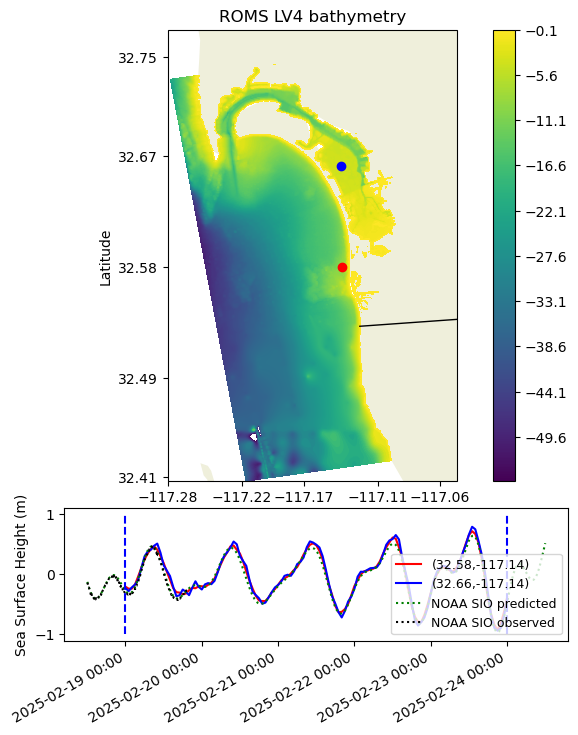

In [2]:


#fn_his = '/scratch/PFM_Simulations/LV1_Forecast/His/LV1_ocean_his_202502120000.nc'
#fn_his = '/scratch/PFM_Simulations/LV2_Forecast/His/LV2_ocean_his_202502120000.nc'
#fn_his = '/scratch/PFM_Simulations/LV3_Forecast/His/LV3_ocean_his_202502120000.nc'
fn_his = '/scratch/PFM_Simulations/LV4_Forecast/His/LV4_ocean_his_202502190000.nc'
#fn_his = '/dataSIO/PFM_Simulations/Archive2.5/LV4_His/LV4_ocean_his_202502120000.nc'
fn_grd = '/scratch/PFM_Simulations/Grids/GRID_SDTJRE_LV4_mss_oct2024.nc'
dir_out = '/scratch/PFM_Simulations/LV4_Forecast/Plots'

webfuns.plot_his_figures_fromnc(fn_his,fn_grd,dir_out)

In [2]:
atmfuns.get_atm_data_on_roms_grid_v2('4')

saving individual lwrad pkl file...
loading /scratch/PFM_Simulations/LV1_Forecast/Forc/atm_tmp_pckl_file.pkl ...
interpolating lwrad to LV 4 grid...
... done.
saving to...
/scratch/PFM_Simulations/LV4_Forecast/Forc/tmp_LV4_lwrad.pkl
...done.
...return code: 0 (0=good)
saving individual lwrad_down pkl file...
loading /scratch/PFM_Simulations/LV1_Forecast/Forc/atm_tmp_pckl_file.pkl ...
interpolating lwrad_down to LV 4 grid...
... done.
saving to...
/scratch/PFM_Simulations/LV4_Forecast/Forc/tmp_LV4_lwrad_down.pkl
...done.
...return code: 0 (0=good)
saving individual swrad pkl file...
loading /scratch/PFM_Simulations/LV1_Forecast/Forc/atm_tmp_pckl_file.pkl ...
interpolating swrad to LV 4 grid...
... done.
saving to...
/scratch/PFM_Simulations/LV4_Forecast/Forc/tmp_LV4_swrad.pkl
...done.
...return code: 0 (0=good)
saving individual rain pkl file...
loading /scratch/PFM_Simulations/LV1_Forecast/Forc/atm_tmp_pckl_file.pkl ...
interpolating rain to LV 4 grid...
... done.
saving to...
/scratch

: 

In [18]:
PFM = get_PFM_info()
fin = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file']
ds  = nc.Dataset(fin)
#print(ds.variables.keys())
tw = ds['wind_time'][:]
dtw = np.round( 24 * np.diff(tw) )
print(dtw)
print(dtw[0])
tst = int(dtw[0])
if tst == 1:
    print('worked')




[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0
worked


In [2]:
yyyymmddhh0 = '2025020600'
res = atmfuns.get_ecmwf_forecast_grbs(yyyymmddhh0)
#print(res)


In [3]:
fns, fns_tot, fns_out, cmd_list = atmfuns.get_ecmwf_grib_files_lists(yyyymmddhh0)
ds = cfgrib.open_file(fns_out[1])
print(sorted(ds.variables))



Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020601001.90c91.idx' older than GRIB file


['d2m', 'e', 'isobaricInhPa', 'latitude', 'longitude', 'msl', 'number', 'q', 'slhf', 'sshf', 'ssr', 'ssrd', 'step', 'strd', 'surface', 't2m', 'tcc', 'time', 'tp', 'ttr', 'u10', 'v10', 'v100', 'valid_time']


In [4]:
#yyyymmddhh0 = '2025020400'
ATM = atmfuns.ecmwf_grib_2_dict_all(yyyymmddhh0)


Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020600011.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020600011.90c91.idx' older than GRIB file


there are 101 ecmwf grib files to stack in time.


Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020601001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020602001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020603001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020604001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020605001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020606001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020607001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020608001.90c91.idx' older than GRIB file
Ignoring index file '/scratch/PFM_Simulations/ecmwf_data/T1D0206002025020609001.90c91.idx' older than GR


ecmwf 1st ATM dict saved with pickle.


In [5]:
dir_out = '/scratch/PFM_Simulations/ecmwf_data/'
fn_in = 'ecmwf_all.pkl'

atmfuns.ecmwf_to_roms_vars(dir_out + fn_in)
atmfuns.get_atm_data_on_roms_grid('1')
atmfuns.atm_roms_dict_to_netcdf('1')



ecmwf ATM dict roms vars saved with pickle.

ATM on roms grid dict saved with pickle.
file_out is:
/scratch/PFM_Simulations/LV1_Forecast/Forc/LV1_ATM_FORCING.nc


In [6]:

pltfuns.load_and_plot_atm('1')


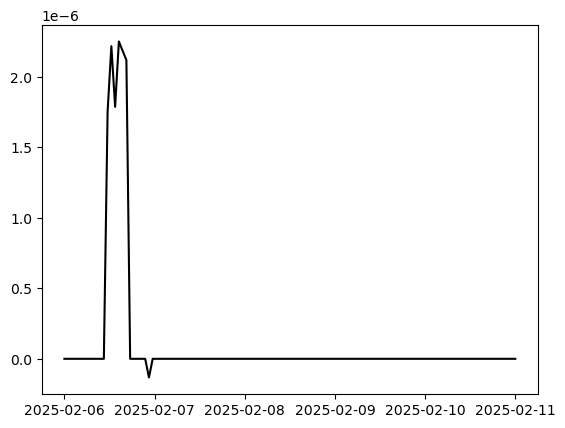

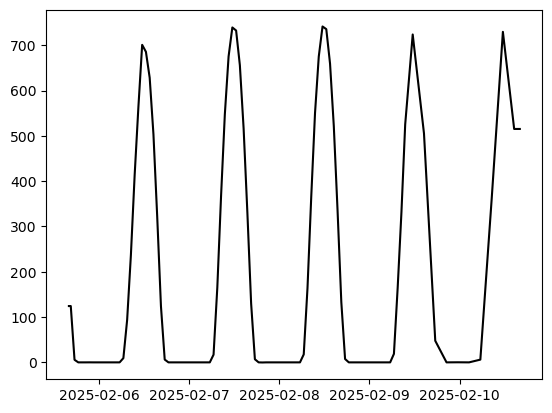

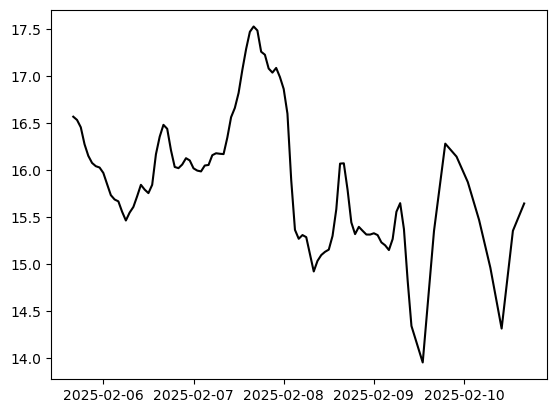

In [10]:
fig, ax = plt.subplots()
pp=ax.plot(ATM2['ocean_time_ref'] + ATM2['rain_time'] * timedelta(days=1),ATM2['rain'][:,-1,-1],'k')

fig, ax = plt.subplots()
pp=ax.plot(ATM2['ocean_time_ref'] + ATM2['rain_time'] * timedelta(days=1) - timedelta(hours=8),ATM2['swrad'][:,-1,-1],'k')

fig, ax = plt.subplots()
pp=ax.plot(ATM2['ocean_time_ref'] + ATM2['ocean_time'] * timedelta(days=1) - timedelta(hours=8),ATM2['Tair'][:,-1,-1],'k')

In [4]:
print(ATM['ssr'][0:24,0,0])

[      0.       81640.       91482.375    91481.       91481.
   91481.0625   91487.8125   91487.875    91487.9375   91487.9375
   91488.       91488.0625   91488.0625   91488.125    91488.1875
   91488.25    103858.125   228123.25    506355.5     896065.0625
 1176211.     1535087.5    1975133.     2151114.    ]


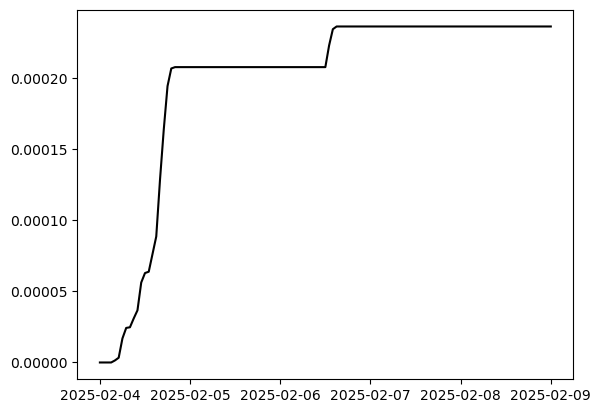

In [7]:
fig, ax = plt.subplots()
pp=ax.plot(ATM['time'],ATM['tp'][:,-1,-1],'k')

#t2 = datetime_to_romstime(ATM['time'])
#print(t2)

In [8]:
def datetime_to_romstime(tdt):
    PFM = get_PFM_info()
    t_ref = PFM['modtime0'] 
    nt = len(tdt)
    t_rom2 = np.zeros((nt))
    for cnt in np.arange(nt):
        t_rom = tdt[cnt] - t_ref # now a timedelta object
        t_rom2[cnt] = t_rom.total_seconds() # now seconds past
        t_rom2[cnt] = t_rom2[cnt] / (3600 * 24) # now days past

    return t_rom2


In [12]:
E  = 6.11 * np.power(10, 7.5 * ATM['d2m'] / (237.7 + ATM['d2m']) )
Es = 6.11 * np.power(10, 7.5 * ATM['t2m'] / (237.7 + ATM['t2m']) )


a = 10
e = np.array([2, 3, 1])
b = np.array([5,6,7])

result = np.power(a, e)
c = b/e
print(c)

print(result)

[2.5 2.  7. ]
[ 100 1000   10]


In [ ]:


yyyymmddhh0 = '2025020300'
fns, fns_tot, fns_out, cmd_list = atmfuns.get_ecmwf_grib_files_lists(yyyymmddhh0)
ds = cfgrib.open_file(fns_out[1])
print(sorted(ds.variables))

print(fns[0:5])
print(cmd_list[0])

atmfuns.ecmwf_grabber(cmd_list[1])




In [5]:
ds = cfgrib.open_file(fns_out[1])
print(sorted(ds.variables))


['d2m', 'e', 'isobaricInhPa', 'latitude', 'longitude', 'msl', 'number', 'q', 'slhf', 'sshf', 'ssr', 'ssrd', 'step', 'strd', 'surface', 't2m', 'tcc', 'time', 'tp', 'ttr', 'u10', 'v10', 'v100', 'valid_time']


In [11]:
'''
https://syntool.cdip.ucsd.edu/thredds/catalog/raw/ECMWF_TMP/FALK/catalog.html
https://syntool.cdip.ucsd.edu/thredds/catalog/raw/ECMWF_TMP/FALK/2025/01/28/catalog.html
https://syntool.cdip.ucsd.edu/thredds/catalog/raw/ECMWF_TMP/FALK/2025/01/28/catalog.html?dataset=RAW/ECMWF_TMP/FALK/2025/01/28/T1S0128182025020318001
User: syntool
Pass: cdip
TS is for the 06 and 18 hr forecasts
T1S0128062025012808001	 TD mmddhh yyyymmddhh 001 or 011 if initial one?
T1S0128062025012807001	   forecast   valid 
T1S0128062025012806011     start time  time

TD is for the 00 and 12 hr forecasts
T1D0128002025012802001	TS mmddhh 
T1D0128002025012801001	
T1D0128002025012800011  first time
T1D0128122025021212001  last time 10+ day forecast?
'''
fn = 'T1D0128002025012800011'
#fn_in = 'https://syntool.cdip.ucsd.edu/thredds/catalog/raw/ECMWF_TMP/FALK/2025/01/28/' + fn
#fn_in = 'https://syntool.cdip.ucsd.edu/thredds/catalog/raw/ECMWF_TMP/FALK/2025/01/28/catalog.html?dataset=RAW/ECMWF_TMP/FALK/2025/01/28/' + fn 
fn_in = 'https://syntool.cdip.ucsd.edu/thredds/fileServer/raw/ECMWF_TMP/FALK/2025/01/28/' + fn #T1D0128002025012801001

fn_out = '/scratch/PFM_Simulations/ecmwf_data/' + fn
#wget --user user --password pass http://example.com/

cmd_lst = ['wget','--user','syntool','--password','cdip','-O',fn_out,fn_in]
ret1 = subprocess.call(cmd_lst)



--2025-01-29 12:38:30--  https://syntool.cdip.ucsd.edu/thredds/fileServer/raw/ECMWF_TMP/FALK/2025/01/28/T1D0128002025012800011
Resolving proxy.ucsd.edu (proxy.ucsd.edu)... 132.239.1.231, 132.239.1.230
Connecting to proxy.ucsd.edu (proxy.ucsd.edu)|132.239.1.231|:3128... connected.
Proxy request sent, awaiting response... 200 
Length: 401822 (392K) [application/octet-stream]
Saving to: ‘/scratch/PFM_Simulations/ecmwf_data/T1D0128002025012800011’

     0K .......... .......... .......... .......... .......... 12% 34.5M 0s
    50K .......... .......... .......... .......... .......... 25% 66.6M 0s
   100K .......... .......... .......... .......... .......... 38% 2.69M 0s
   150K .......... .......... .......... .......... .......... 50% 54.9M 0s
   200K .......... .......... .......... .......... .......... 63% 6.79M 0s
   250K .......... .......... .......... .......... .......... 76% 63.2M 0s
   300K .......... .......... .......... .......... .......... 89% 5.36M 0s
   350K .......... 

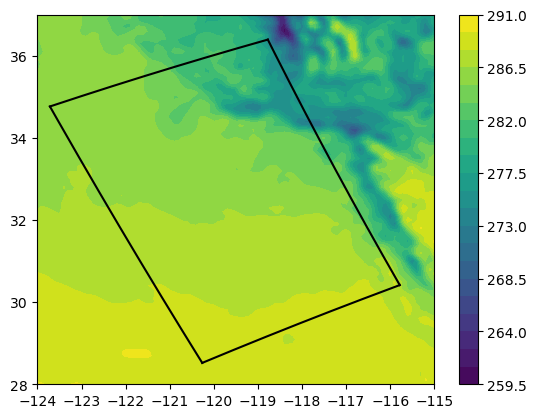

In [63]:
import cfgrib
#import xarray as xr
#fn = 'T1D0128002025012800011'
fn = 'T1S0127182025012718011'
fn_out = '/scratch/PFM_Simulations/ecmwf_data/' + fn
#ds = xr.open_dataset(fn_out, engine='cfgrib')
#ds = cfgrib.open_file(fn_out)
A = ecmwf_grib_2_dict(fn_out)

#print(A['valid_time'])
#print(A['latitude'])
#print(A['longitude'])
#print(A['tp'][:,0])

fig, ax = plt.subplots()
#p1 = ax.imshow(A['t2m'])
#lvls = [1.25, 1.5]
p1 = ax.contourf(A['longitude'],A['latitude'],A['t2m'], levels=20)
#ax.plot(ixs,iys,'r')
#ax.invert_yaxis()
fig.colorbar(p1,ax=ax)

fng = '/scratch/PFM_Simulations/Grids/GRID_SDTJRE_LV1_rx020_hmask.nc'
RMG = grdfuns.roms_grid_to_dict(fng)
pp=ax.plot(RMG['lon_rho'][0,:],RMG['lat_rho'][0,:],'k')
pp=ax.plot(RMG['lon_rho'][-1,:],RMG['lat_rho'][-1,:],'k')
pp=ax.plot(RMG['lon_rho'][:,0],RMG['lat_rho'][:,0],'k')
pp=ax.plot(RMG['lon_rho'][:,-1],RMG['lat_rho'][:,-1],'k')



In [57]:
def ecmwf_grib_2_dict(fn_in):
    AA = dict()
    # these are the 2d variables we need in the ecmwf grib file
    # see https://code.usgs.gov/coawstmodel/COAWST/-/blob/v3.7-marsh/Tools/mfiles/rutgers/forcing/d_ecmwf2roms.m
    var_e = ['d2m','t2m','msl','u10','v10','e','tp','slhf','sshf','ssr','strd'] # need 'str' !!!
    var_info = dict()
    var_info['valid_time'] = 'time since 1970-1-1 in seconds'
    var_info['time'] = 'time stamp in datetime'
    var_info['latitude'] = 'vector of latatides at 0.1 deg resolution'
    var_info['longitude'] = 'vector of longitudes at 0.1 deg resolution'
    var_info['d2m'] = '2 m dew point temp in K'
    var_info['t2m'] = '2 m temp in K'
    var_info['msl'] = 'mean sea level pressure'
    var_info['u10'] = '10 m east west velocity in m/s'
    var_info['v10'] = '10 m north south velocity in m/s'
    var_info['e'] = 'evaporation in m, over 1 or 3 hr?'
    var_info['tp'] = 'total precipitation in m, over 1 or 3 hr?'
    var_info['slhf'] = 'surface latent heat flux in J/m2, over 1 or 3 hr?'
    var_info['sshf'] = 'surface sensible heat flux in J/m2, over?'
    var_info['ssr'] = 'net surface shortwave radiation in J/m2, over?'
    var_info['str'] = 'net surface thermal (long wave) radiation in J/m2, over?'
    var_info['strd'] = 'surface thermal radiation downward'
    AA['var_info'] = var_info
    ds = cfgrib.open_file(fn_in)
    AA['valid_time'] = ds.variables['valid_time'].data
    AA['latitude'] = ds.variables['latitude'].data[:]
    AA['longitude'] = ds.variables['longitude'].data[:]
    for vnm in var_e:
        AA[vnm] = ds.variables[vnm].data[:,:]

    tsec = AA['valid_time']
    time = datetime(year=1970,month=1,day=1) + tsec * timedelta(seconds=1)
    AA['time'] = time
    return AA



In [56]:
ds = cfgrib.open_file()


print(sorted(ds.variables))
dum=ds.variables['valid_time'] # number of seconds past 1970-1-1.
#dum=ds.variables['time'] # this is the intialization time, seconds past 1970-1-1, of the forecast
#dum=ds.variables['e'] # evaportation m or water 
#dum=ds.variables['latitude'] # a 91x1 vector at 0.1 deg resolution
#dum=ds.variables['longitude'] # a 91x1 vector at 0.1 deg resolution
#dum=ds.variables['d2m'] #  282 ? dew point temp 2m? K
#dum=ds.variables['t2m']  # 285 2m temp K
#dum=ds.variables['q']  # specific humidity kg kg^-1 (4e-6)
#dum=ds.variables['msl']  # mean sea level pressure Pa
#dum=ds.variables['u10'] # 10 m u m/s
#dum=ds.variables['v10'] # 10 m v m/s
#dum = ds.variables['ssrd'] # surface solor radiation down J/m^2 (over what time?)
#dum = ds.variables['strd'] # surface thermal radiation down J/m^2 (over what time?)
#dum = ds.variables['ssr'] # net solor radiation  J/m^2 (over what time?)
#dum = ds.variables['str'] # net thermal radiation  J/m^2 (over what time?)
#dum = ds.variables['sshf'] # sensible heat flux  J/m^2 (over what time?)
#dum = ds.variables['slhf'] # latent heat flux  J/m^2 (over what time?)
#dum = ds.variables['tcc'] # total cloud cover 0-1.
#dum = ds.variables['step'] # 0, not sure
#dum = ds.variables['tp'] # total precipitation meters 

t_valid=ds.variables['valid_time'].data
#t_valid=ds.variables['time'].data

print(t_valid)
print(t_valid/24/60/60)
t_ref = datetime(year=1970,month=1,day=1)
print(datetime.now()-t_ref)
tt = t_ref + t_valid * timedelta(seconds=1)

print(tt)


['d2m', 'e', 'isobaricInhPa', 'latitude', 'longitude', 'msl', 'number', 'q', 'slhf', 'sshf', 'ssr', 'ssrd', 'step', 'strd', 'surface', 't2m', 'tcc', 'time', 'tp', 'ttr', 'u10', 'v10', 'v100', 'valid_time']
1738000800.0
20115.75
20123 days, 11:02:46.457812
2025-01-27 18:00:00


In [3]:
yyyymmddhh = '2024101012'
cl,fnout = ocnfuns.get_hind_nc_cmd_list(yyyymmddhh)
print(cl[-2])
print(fnout[-2])

print(len(fnout))

['ncks', '-q', '-D', '0', '-d', 'time,2024-10-11T11:00,2024-10-11T11:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'surf_el', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/ssh/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_23_ssh.nc']
/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_23_ssh.nc
61


In [1]:
def get_hycom_hind_nc_names(yyyymmddhh):
    # this gets the list of nc files on the hycom server that we need to get.
    t1 = datetime.strptime(yyyymmddhh,'%Y%m%d%H')
    t2 = t1 + timedelta(days=1)
    yyyymmddhh_2 = t2.strftime("%Y%m%d%H")

    yyyy = yyyymmddhh[0:4]
    yyyy2 = yyyymmddhh_2[0:4]

    # for the 1st day we use
    ocn_name = 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/'
    #            https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/ssh/2024
    #https://tds.hycom.org/thredds/dodsC/FMRC_ESPC-D-V02_ssh/runs/FMRC_ESPC-D-V02_ssh_RUN_2025-01-08T12:00:00Z

    # and we need the first time of the next day too for boundary conditions
    
    var_names = ['s3z','t3z','u3z','v3z','ssh']

    ncfiles1 = [] # list of urls for the 1st day

    # first do the 1st day
    for bb in var_names:
        ffn = ocn_name + bb + '/' + yyyy 
        ncfiles1.append(ffn)

    return ncfiles1

In [2]:
PFM=get_PFM_info()
print(PFM['fetch_time'])

2024-10-10 12:00:00


In [4]:
yyyymmddhh = '2024101012'
fns = get_hycom_hind_nc_names(yyyymmddhh)
print(fns[0])




https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024


In [2]:
#fns2 = ocnfuns.hycom_to_out(fns)
#print(fns2[0])
yyyymmddhh = PFM['fetch_time'].strftime("%Y%m%d%H")
print(yyyymmddhh)

cmd_list, nc_out = ocnfuns.get_hind_nc_cmd_list(yyyymmddhh)
ret = ocnfuns.get_hycom_hind_data(yyyymmddhh)
print(sum(ret))



[['ncks', '-q', '-D', '0', '-d', 'time,2024-10-10T11:30,2024-10-10T12:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'salinity', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_00_s3z.nc'], ['ncks', '-q', '-D', '0', '-d', 'time,2024-10-10T14:30,2024-10-10T15:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'salinity', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_03_s3z.nc'], ['ncks', '-q', '-D', '0', '-d', 'time,2024-10-10T17:30,2024-10-10T18:30', '-d', 'lon,236.14718692090975,244.3526828277587', '-d', 'lat,28.36036255692185,36.55363973083988', '-v', 'salinity', 'https://tds.hycom.org/thredds/dodsC/ESPC-D-V02/s3z/2024', '-4', '-O', '/scratch/PHM_Simulations/hycom_data/hycom_hind_2024101012_06_s3z.nc'

In [3]:

ocnfuns.hycom_hind_ncfiles_to_pickle()

PFM = get_PFM_info()
fn_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocn_tmp_pckl_file']
os.chdir('../sdpm_py_util')
print('putting the hycom data in ' + fn_pckl + ' on the roms grid...')
cmd_list = ['python','-W','ignore','ocn_functions.py','make_all_tmp_pckl_ocnR_files_1hrzeta',fn_pckl]
os.chdir('../sdpm_py_util')
ret1 = subprocess.run(cmd_list)     
#ocnfuns.make_all_tmp_pckl_ocnR_files(fn_pckl)
os.chdir('../driver')
print('subprocess return code? ' + str(ret1.returncode) +  ' (0=good)')




max and min raw hycom data (iz is top [0] to bottom [39]):
max zeta   =  0.845 m          at  ( it, ilat, ilon)     =  ( 10,  68,  94)
min zeta   = -0.995 m          at  ( it, ilat, ilon)     =  ( 19, 203,   0)
max u      =  0.608 m/s        at  ( it, iz, ilat, ilon) =  (  7,  8,  74,  53)
min u      = -0.580 m/s        at  ( it, iz, ilat, ilon) =  (  8,  2,  41,  76)
max v      =  0.531 m/s        at  ( it, iz, ilat, ilon) =  (  3,  6,  36,  90)
min v      = -0.630 m/s        at  ( it, iz, ilat, ilon) =  (  2,  0, 153,   7)
max temp   = 22.294 C          at  ( it, iz, ilat, ilon) =  (  4,  0,  12,   2)
min temp   =  1.368 C          at  ( it, iz, ilat, ilon) =  (  7, 38, 170,   4)
max dT/dz  =  1.398 C/m        at  ( it, iz, ilat, ilon) =  (  0,  1, 125,  77)
min dT/dz  = -0.137 C/m        at  ( it, iz, ilat, ilon) =  (  4, 13, 121,  56)
max salt   = 34.731 psu        at  ( it, iz, ilat, ilon) =  (  0, 37,  50,  79)
min salt   = 32.586 psu        at  ( it, iz, ilat, ilon) =  (  1, 14

In [4]:
cmd_list = ['python','-W','ignore','ocn_functions.py','print_maxmin_HYrm_pickles']
os.chdir('../sdpm_py_util')
ret1 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('driver_run_forecast_LV1: done with hycom_to_roms_latlon')



max and min of hycom data on ROMS grid (iz is top [0] to bottom [39]):
max zeta   =  0.832 m          at  ( it, ilat, ilon)     =  ( 10,  52, 245)
min zeta   = -0.950 m          at  ( it, ilat, ilon)     =  ( 18, 351, 141)
max urm    =  0.613 m/s        at  ( it, iz, ilat, ilon) =  (  7,  8, 132, 100)
min urm    = -0.655 m/s        at  ( it, iz, ilat, ilon) =  (  8,  0,  23, 150)
max vrm    =  0.508 m/s        at  ( it, iz, ilat, ilon) =  (  2,  7, 350, 112)
min vrm    = -0.672 m/s        at  ( it, iz, ilat, ilon) =  (  2,  0, 366,  12)
max temp   = 22.160 C          at  ( it, iz, ilat, ilon) =  (  4,  0, 209, 191)
min temp   =  1.404 C          at  ( it, iz, ilat, ilon) =  (  7, 38, 216,  11)
max dT/dz  =  1.388 C/m        at  ( it, iz, ilat, ilon) =  (  4,  0,  25, 247)
min dT/dz  = -0.348 C/m        at  ( it, iz, ilat, ilon) =  (  5,  6,   2, 240)
max salt   = 34.731 psu        at  ( it, iz, ilat, ilon) =  (  0, 37,  11, 227)
min salt   = 32.624 psu        at  ( it, iz, ilat, ilon)

In [5]:
print('making the depth pickle file...')
fname_depths = PFM['lv1_forc_dir'] + '/' + PFM['lv1_depth_file']
cmd_list = ['python','-W','ignore','ocn_functions.py','make_rom_depths_1hrzeta',fname_depths]
os.chdir('../sdpm_py_util')
ret6 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('subprocess return code? ' + str(ret6.returncode) +  ' (0=good)')


making the depth pickle file...
making roms depth pickle file /scratch/PHM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pkl...
ROMS depths for IC/BC saved with pickle to /scratch/PHM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pkl
...done makeing depth pickle file.
subprocess return code? 0 (0=good)


In [6]:
ocnIC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnIC_tmp_pckl_file']
ic_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ini_file']
bc_file_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_bc_file']
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
fn_atm_out = PFM['lv1_forc_dir'] + '/' + PFM['lv1_atm_file'] # LV1 atm forcing filename


In [8]:
t01=datetime.now()
print('going to save OCN_IC to a pickle file: ' + ocnIC_pckl)
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocnr_2_ICdict_from_tmppkls',ocnIC_pckl]
ret3 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN IC data saved with pickle, correctly? ' + str(ret3.returncode) + ' (0=yes,1=no)')

print('driver_run_forecast_LV1: done with ocn_r_2_ICdict')
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')

print('making IC file from pickled IC: '+ ic_file_out)
t03 = datetime.now()
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_IC_dict_to_netcdf_pckl',ocnIC_pckl,ic_file_out]
os.chdir('../sdpm_py_util')
ret4 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN IC nc data saved, correctly? ' + str(ret4.returncode) + ' (0=yes)')


going to save OCN_IC to a pickle file: /scratch/PHM_Simulations/LV1_Forecast/Forc/ocnIC_tmp_pckl_file.pkl
OCN_IC dict saved with pickle
OCN IC data saved with pickle, correctly? 0 (0=yes,1=no)
driver_run_forecast_LV1: done with ocn_r_2_ICdict
this took:
0:00:27.988974


making IC file from pickled IC: /scratch/PHM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_IC.nc
OCN_IC dict loaded with pickle

max and min of data in ROMS IC file (iz is bottom [0] to top [39], note: it is always 0 b/c IC):
max zeta   =  0.340 m          at  ( it, ilat, ilon)     =  (  0,  80,  63)
min zeta   =  0.016 m          at  ( it, ilat, ilon)     =  (  0, 156, 103)
max ubar   =  0.156 m/s        at  ( it, ilat, ilon)     =  (  0, 173, 214)
min ubar   = -0.270 m/s        at  ( it, ilat, ilon)     =  (  0, 309, 136)
max vbar   =  0.233 m/s        at  ( it, ilat, ilon)     =  (  0, 322, 123)
min vbar   = -0.133 m/s        at  ( it, ilat, ilon)     =  (  0, 157, 229)
max u      =  0.502 m/s        at  ( it, iz, ilat, il

In [9]:
print('going to save OCN_BC to a pickle file to:')
t01 = datetime.now()
t04 = datetime.now()
ocnBC_pckl = PFM['lv1_forc_dir'] + '/' + PFM['lv1_ocnBC_tmp_pckl_file']
print(ocnBC_pckl) 
os.chdir('../sdpm_py_util')
cmd_list = ['python','-W','ignore','ocn_functions.py','ocnr_2_BCdict_1hrzeta_from_tmppkls',ocnBC_pckl]
ret4 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN BC data saved with pickle, correctly? ' + str(ret4.returncode) + ' (0=yes)')
    
t02 = datetime.now()
print('this took:')
print(t02-t01)
print('\n')


print('making BC nc file from pickled BC: '+ bc_file_out)
t01 = datetime.now()
cmd_list = ['python','-W','ignore','ocn_functions.py','ocn_roms_BC_dict_to_netcdf_pckl_1hrzeta',ocnBC_pckl,bc_file_out]
os.chdir('../sdpm_py_util')
ret5 = subprocess.run(cmd_list)     
os.chdir('../driver')
print('OCN BC nc data saved, correctly? ' + str(ret5.returncode) + ' (0=yes)')

print('done makeing BC nc file.')



going to save OCN_BC to a pickle file to:
/scratch/PHM_Simulations/LV1_Forecast/Forc/ocnBC_tmp_pckl_file.pkl
loading /scratch/PHM_Simulations/LV1_Forecast/Forc/roms_tmp_depth_file.pkl
OCN_BC dict saved with pickle
OCN BC data saved with pickle, correctly? 0 (0=yes)
this took:
0:00:03.446905


making BC nc file from pickled BC: /scratch/PHM_Simulations/LV1_Forecast/Forc/LV1_OCEAN_BC.nc
OCN_BC dict loaded with pickle

max and min of data in ROMS BC file (iz is bottom [0] to top [39]):
max zeta_north =  0.736 m          at  ( it, ilon)     =  ( 11, 128)
min zeta_north = -0.893 m          at  ( it, ilon)     =  ( 19,  99)
max zeta_south =  0.753 m          at  ( it, ilon)     =  ( 10,  68)
min zeta_south = -0.722 m          at  ( it, ilon)     =  ( 18, 158)
max zeta_west  =  0.764 m          at  ( it, ilat)     =  ( 11, 317)
min zeta_west  = -0.755 m          at  ( it, ilat)     =  ( 19, 221)
max ubar_north =  0.018 m/s        at  ( it, ilon)     =  (  6, 108)
min ubar_north = -0.061 m/s  

In [4]:
import cfgrib

#grb2_in = "https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241231/nam_218_20241231_0000_000.grb2" 
#grb2_in = "https://www.ncei.noaa.gov/thredds/catalog/model-namanl/202412/20241231/nam_218_20241231_0000_000.grb2"
grb2_out = "/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_003.grb2"


ds = xr.open_dataset(grb2_out, engine='cfgrib')
#ds = cfgrib.open_file(grb2_out)


#with open(grb2_out, 'rb') as f:
#    grbs = grib2io.open(f)


#g = grib2io.open(grb2_out)

print(ds)

#strt = 0
#g.seek(strt)
#print('GRIB2 file poistion: ',g.tell())
#msgs = g.read(500)
#print('Number of messages read: ',len(msgs))
#for msg in msgs:
#    print(msg)

#for a in np.arange(0,1):
#print(g['LWRAD'])


DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'hybrid'}
    filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'cloudTop'}
    filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
    filter_by_keys={'typeOfLevel': 'depthBelowLand'}
    filter_by_keys={'typeOfLevel': 'lowestLevelWetBulb0'}
    filter_by_keys={'typeOfLevel': 'isobaricLayer'}
    filter_by_keys={'typeOfLevel': 'cloudBase'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'tropopause'}
    filter_by_keys={'typeOfLevel': 'maxWind'}
    filter_by_keys={'typeOfLevel': 'isothermZero'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigmaLayer'}

In [ ]:

# the variables and levels we need
vars=['PRMSL','RH','TMP','UGRD','VGRD','APCP','DSWRF','USWRF','DLWRF','ULWRF']
lev =['mean sea level','2 m above ground','2 m above ground','10 m above ground','10 m above ground','surface','surface','surface','surface','surface']

apcp = g.select(shortName='APCP',level='surface')[0]
print('\nprinting apcp')
#print(g.select(shortName='APCP',level='surface'))
print(apcp)
print(apcp.validDate,type(apcp.validDate))
print(apcp.duration,type(apcp.duration))
# note, this is not a regular grid. It is on the native grid.

#print(lats[:,0])
#print(lons[0,:])

tmp = g.select(shortName='TMP',level='2 m above ground')[0]
print('\nprinting tmp')
print(tmp)

lats, lons = tmp.grid()

rh = g.select(shortName='RH',level='2 m above ground')[0]
print('\nprinting rh')
print(rh.data[0:10,0])


pmsl = g.select(shortName='PRMSL',level='mean sea level')[0]
print('\nprinting pmsl')
print(pmsl)
u10 = g.select(shortName='UGRD',level='10 m above ground')
print('\nprinting u10')
print(u10)
#pmsl = g.select(shortName=vars[0])[0]
#print(pmsl)
#pmsl_data = pmsl.data
#print(pmsl_data[0:10,0:10])

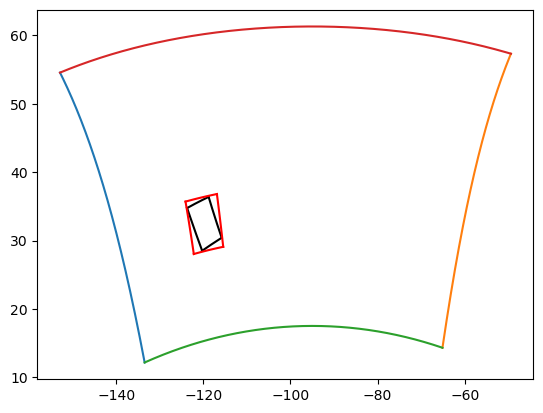

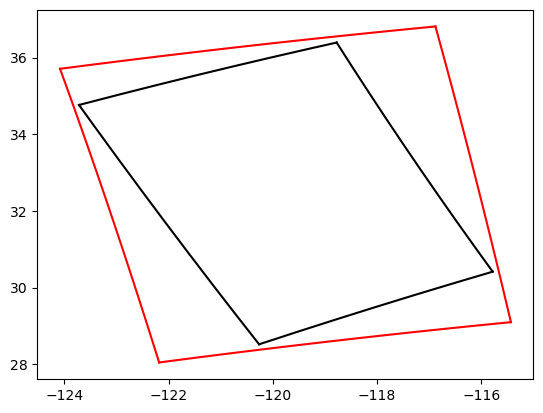

In [81]:
fng = '/scratch/PFM_Simulations/Grids/GRID_SDTJRE_LV1_rx020_hmask.nc'
RMG = grdfuns.roms_grid_to_dict(fng)

fig, ax = plt.subplots()

y1=lats[:,0]
x1=lons[:,0]
y2=lats[:,-1]
x2=lons[:,-1]
y3=lats[0,:]
x3=lons[0,:]
y4=lats[-1,:]
x4=lons[-1,:]

lt_mn = 118
lt_mx = 191
ln_mn = 129
ln_mx = 185
lons2 = lons[lt_mn:lt_mx,ln_mn:ln_mx]
lats2 = lats[lt_mn:lt_mx,ln_mn:ln_mx]

p1=ax.plot(x1,y1)
p1=ax.plot(x2,y2)
p1=ax.plot(x3,y3)
p1=ax.plot(x4,y4)
p1=ax.plot(RMG['lon_rho'][0,:],RMG['lat_rho'][0,:],'k')
p1=ax.plot(RMG['lon_rho'][-1,:],RMG['lat_rho'][-1,:],'k')
p1=ax.plot(RMG['lon_rho'][:,0],RMG['lat_rho'][:,0],'k')
p1=ax.plot(RMG['lon_rho'][:,-1],RMG['lat_rho'][:,-1],'k')

p1=ax.plot(lons2[0,:],lats2[0,:],'r')
p1=ax.plot(lons2[-1,:],lats2[-1,:],'r')
p1=ax.plot(lons2[:,0],lats2[:,0],'r')
p1=ax.plot(lons2[:,-1],lats2[:,-1],'r')

fig, ax = plt.subplots()
p1=ax.plot(RMG['lon_rho'][0,:],RMG['lat_rho'][0,:],'k')
p1=ax.plot(RMG['lon_rho'][-1,:],RMG['lat_rho'][-1,:],'k')
p1=ax.plot(RMG['lon_rho'][:,0],RMG['lat_rho'][:,0],'k')
p1=ax.plot(RMG['lon_rho'][:,-1],RMG['lat_rho'][:,-1],'k')

p1=ax.plot(lons2[0,:],lats2[0,:],'r')
p1=ax.plot(lons2[-1,:],lats2[-1,:],'r')
p1=ax.plot(lons2[:,0],lats2[:,0],'r')
p1=ax.plot(lons2[:,-1],lats2[:,-1],'r')



In [20]:
#tnow = datetime.now()
#hr = tnow.hour

hr = 24
hr = hr % 24
hr2 = hr % 6
hr1 = hr-hr2

print(hr1,hr2)

t1str = '2024120100'
t2str = '2024120200'
l1,l2,l3,l4 = hindfuns.get_nam_hindcast_filelists(t1str,t2str)
print(l3)
print(l4)

#res2 = hindfuns.get_nam_hindcast_grb2s(t1str,t2str)


0 0
[['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0000_000.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_003.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0000_003.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_000.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0600_000.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0600_003.grb2', 'https://www.ncei.noaa.gov/data/north-american-mesoscale-model/access/analysis/202412/20241201/nam_218_20241201_0600_003.grb2'], ['wget', '-q', '-O', '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_1200_000.grb2', 'https://www.ncei.noaa.gov/da

In [19]:
tnow = datetime.now()
tref = datetime.strptime('19990101','%Y%m%d')
Dt = tnow - tref
dys = Dt.total_seconds() / (24.0*3600.0)
print(dys)


9519.61517401456


AttributeError: 'float' object has no attribute 'total_days'

In [2]:
fn_in = '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.grb2'
fn_out = '/scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.pckl'
hindfuns.grb2_to_pickle(fn_in,fn_out)

ATM grb2 file /scratch/PHM_Simulations/grb2_data/nam_218_20241201_0000_000.grb2 saved to pickle.
